# Nea. ancestry trajectories under different demographic models

This is a simple analysis of the effect of demography ($N_e$ in particular) after the out of Africa bottleneck on the efficacy of selection against weakly deleterious mutations introgressed from Neanderthals.

Neanderthal ancestry in the population is measured on 10,000 exonic sites and 40,000 non-exonic sites carrying fixed neutral Nea. markers. The positions of these sites were subsampled from the coordinates of sites from the archaic admixture array. Deleterious mutations are accumulating in exonic regions only.

I considered three demographic models (example in the plot bellow):

* classic Gravel et al. demographic model
* model of a constant $N_e = 10000$
* model of an initial linear growth until $N_e = 10000$ followed by a period exponential growth

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))

Conflicts with tidy packages ---------------------------------------------------


In [2]:
traject_dir <- "../simulations/different_models"

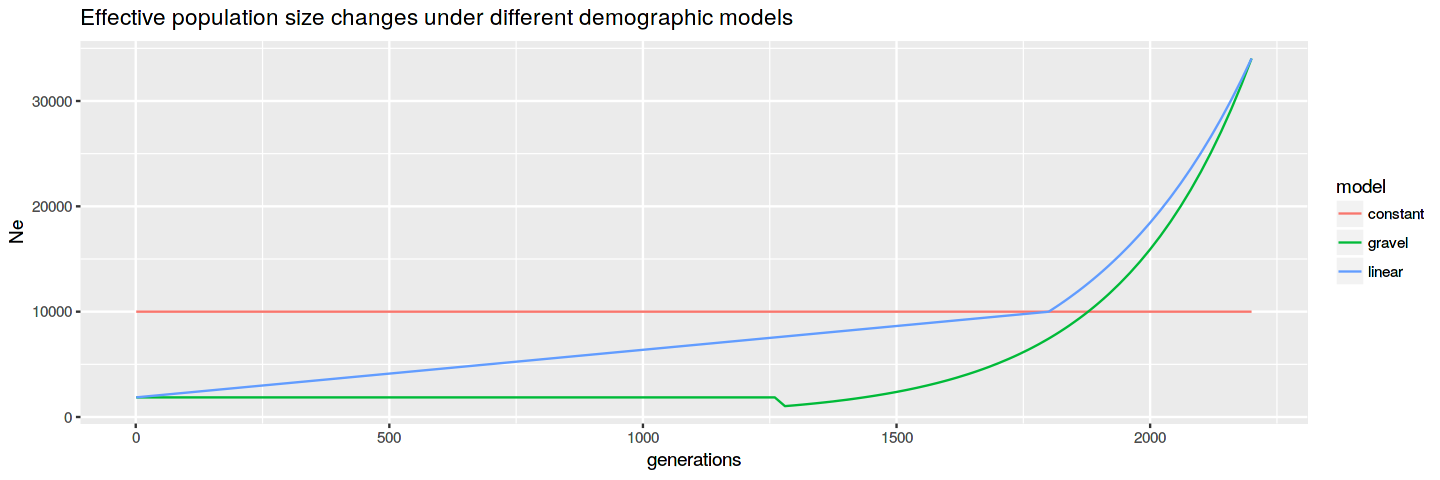

In [3]:
options(repr.plot.width=12, repr.plot.height=4)

# the custom SLiM output format includes a column with a Ne at each time-point
# this simply plots the values in this column for different simulation replicates
rbind(
    read.table(file.path(traject_dir, "constant__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE) %>% mutate(model="constant"),
    read.table(file.path(traject_dir, "gravel__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="gravel"),
    read.table(file.path(traject_dir, "linear__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="linear")
) %>%
ggplot(aes(gen, Ne, color=model)) +
    geom_line() +
    labs(title="Effective population size changes under different demographic models",
         x="generations")

### Function definitions

In [4]:
##
## Create a data frame with Nea. trajectories from all replicates.
##
load_trajectories <- function(sim_dir, scenario, h, init_nea, sites_subset) {
    if (!sites_subset %in% c("exonic", "nonexonic"))
        stop("Illegal subset of sites specified (must be \"exonic\" or \"nonexonic\").")

    # compose the pattern describing all input tables
    pattern <- paste0(scenario,
                      "__h_", h,
                      "__init_nea_", init_nea,
                      "__rep_.*",
                      "__", sites_subset, "_sites.txt")

    # get paths of all input tables
    files <- list.files(sim_dir, pattern, full.names=TRUE)

    # load each table individually
    tables <- lapply(seq_along(files),
           function(i) {
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=i,
                              model=scenario,
                              sites=sites_subset)
           })

    # merge all dataframes into one and return the result
    do.call(rbind, tables)
}


##
## Calculate and plot the trajectory of a given statistic of the Neanderthal
## ancestry in a population.
##
plot_statistic <- function(trajectories, statistic, log_scale=FALSE) {
    options(repr.plot.width=12, repr.plot.height=4)

    # calculate the mean of a given summary statistic over all replicates
    summarized <-
        group_by(trajectories, gen, sites, model) %>%
        summarize_(statistic=interp(~mean(var), var = as.name(statistic)))
    
    p <-
        ggplot(summarized, aes(gen, statistic)) +
            geom_line(aes(color=sites)) +
            facet_grid(. ~ model) + ylim(0, 0.125) +
            labs(title=paste("mean of the",
                             paste0(statistic, "s"),
                             "of Nea. ancestry change on the",
                             ifelse(log_scale, "log time scale", "normal time scale")),
                 y=statistic,
                 x="generations")
    
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    
    p
}


##
## Plot individual trajectories of a given statistic for each simulation
## replicate separately.
##
plot_replicates <- function(trajectories, statistic, log_scale=FALSE) {
    options(repr.plot.width=12, repr.plot.height=8)

    p <- 
        melt(trajectories, id=c("gen", "rep", "model", "sites"), measure=c(statistic)) %>%
        ggplot(aes(gen, value)) +
            geom_line(aes(color=factor(rep))) +
            facet_grid(model ~ sites) +
            ylim(0, 0.125) +
            labs(title=paste(statistic,
                             "Nea. ancestry change on the",
                             ifelse(log_scale, "log time scale", "normal time scale")),
                 y=statistic,
                 x="generations")
    
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    
    p
}

### Load Nea. trajectories for all simulated models measured on the two types of Nea. neutral markers

The following measures of the Neanderthal ancestry in a population at a given time were recorded:

* mean
* median
* standard deviation
* min and max

In [5]:
sites <- c("exonic", "nonexonic")
models <- c("constant", "linear", "gravel")

In [6]:
trajectories <-
    expand.grid(model=models, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["model"], h="0.5", init_nea="0.1", comb["site"])
    }) %>%
    do.call(rbind, .)

## Mean Nea. ancestry over time

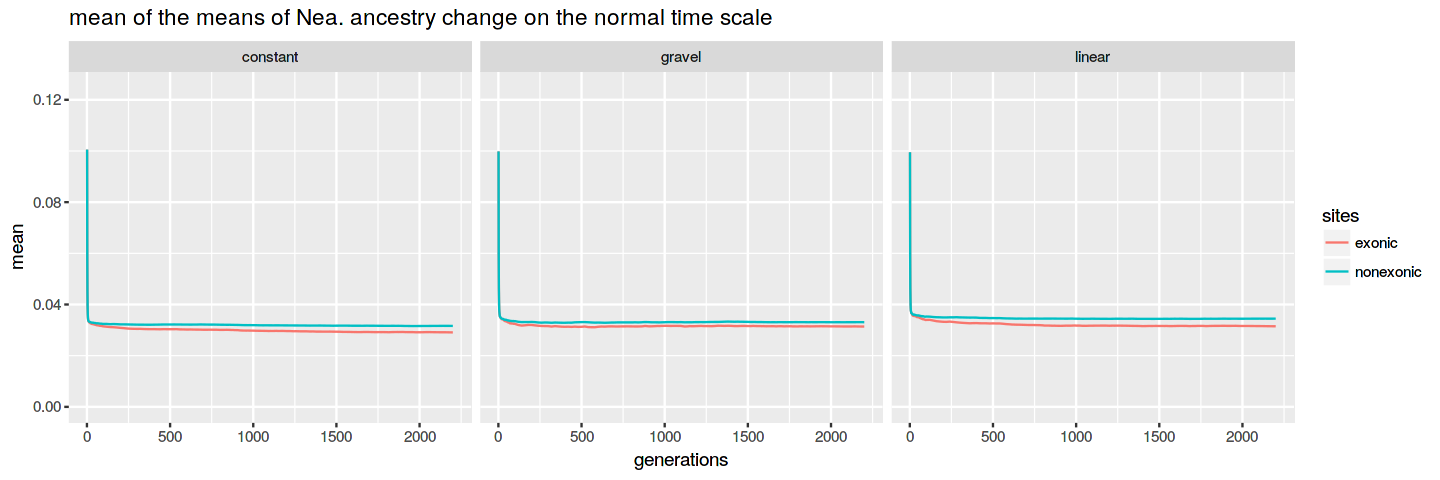

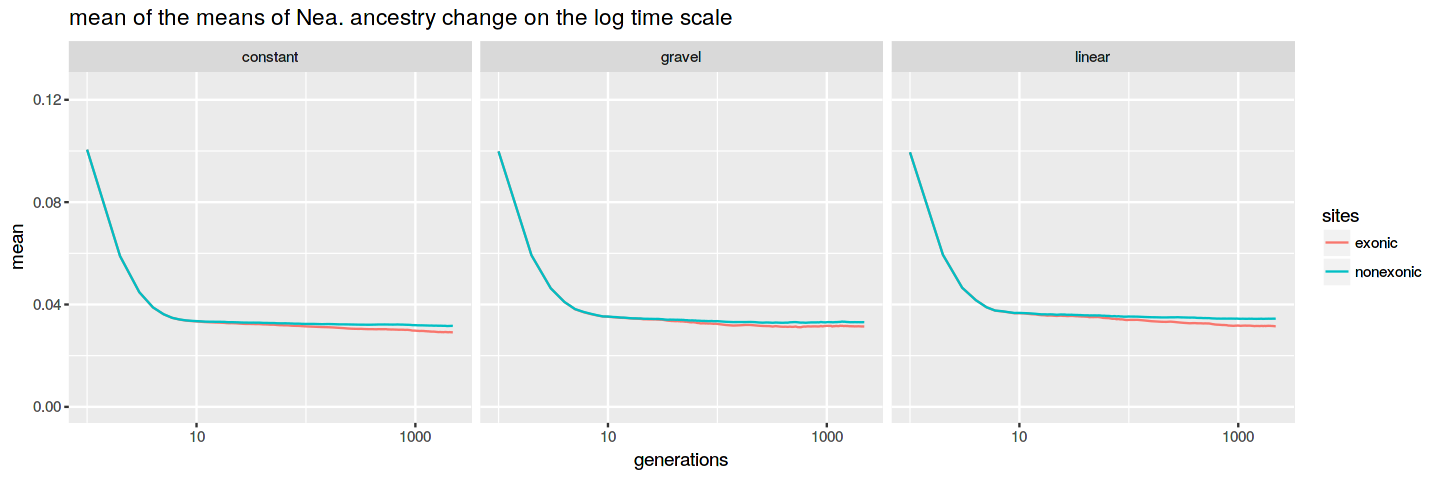

In [7]:
plot_statistic(trajectories, "mean")
plot_statistic(trajectories, "mean", log_scale=TRUE)

## Median of the Nea. ancestry over time

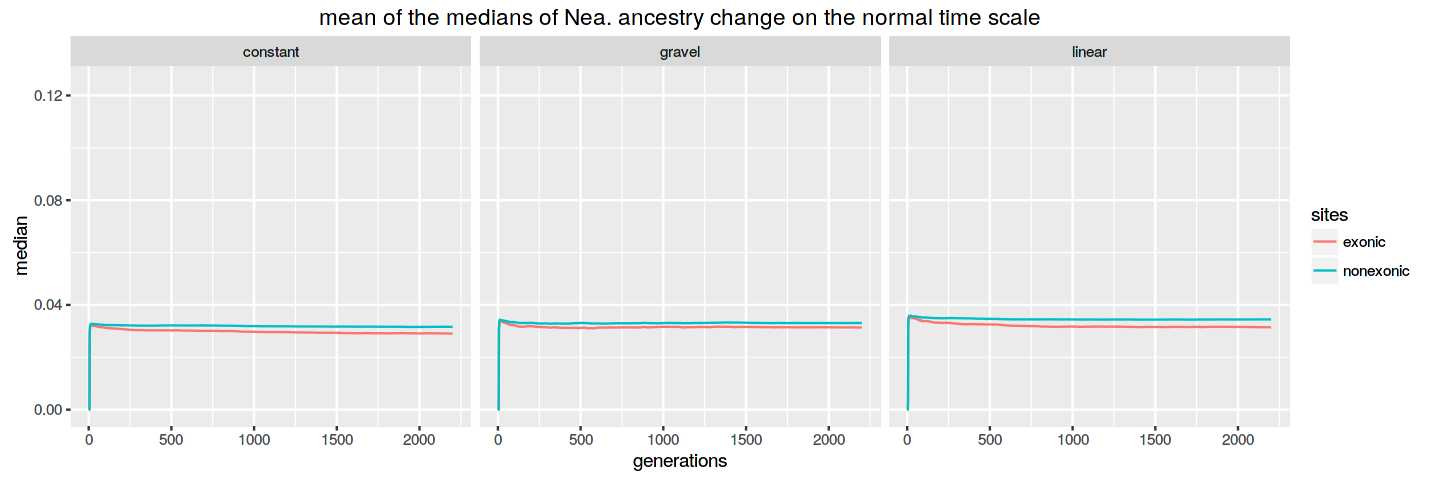

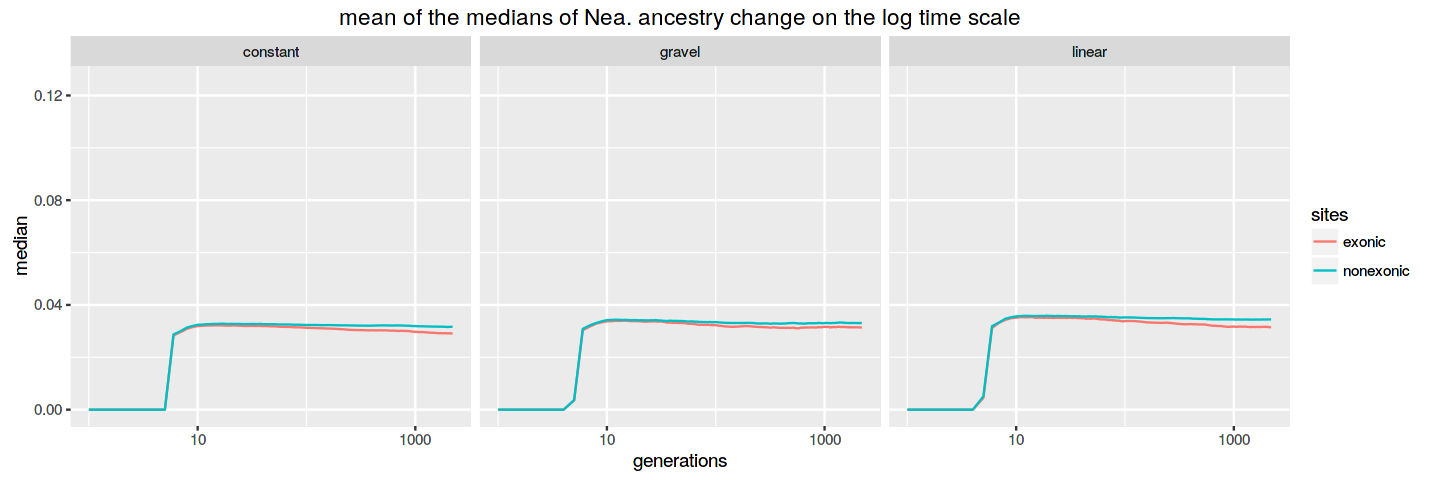

In [8]:
plot_statistic(trajectories, "median")
plot_statistic(trajectories, "median", log_scale=TRUE)

## Standard deviation of the Nea. ancestry over time

Warning message:
“Removed 4 rows containing missing values (geom_path).”

Warning message:
“Removed 4 rows containing missing values (geom_path).”

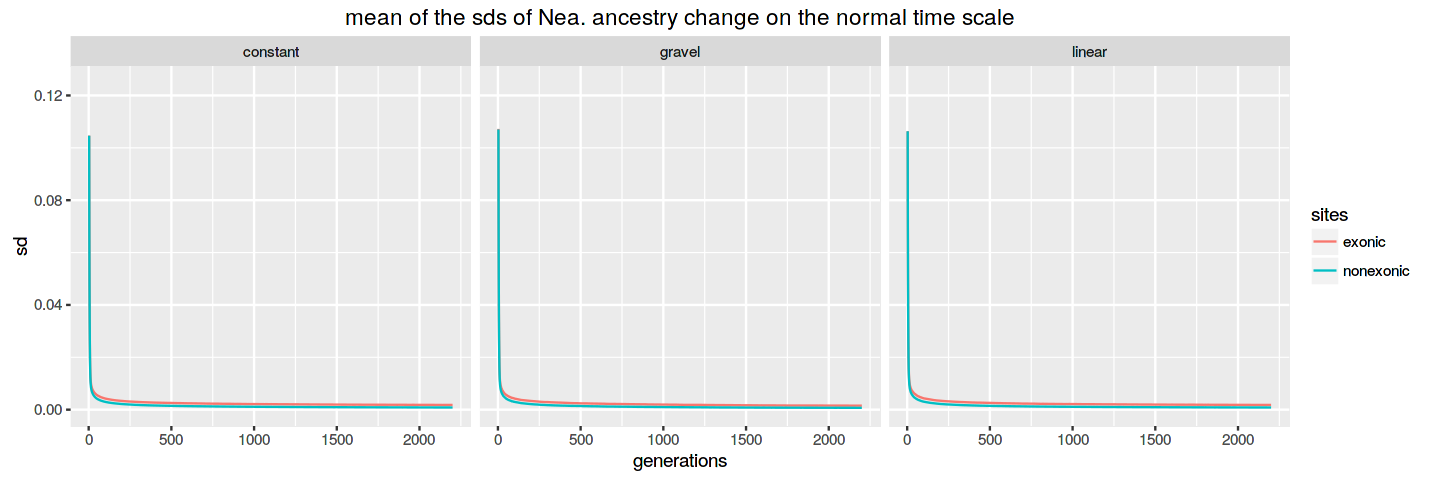

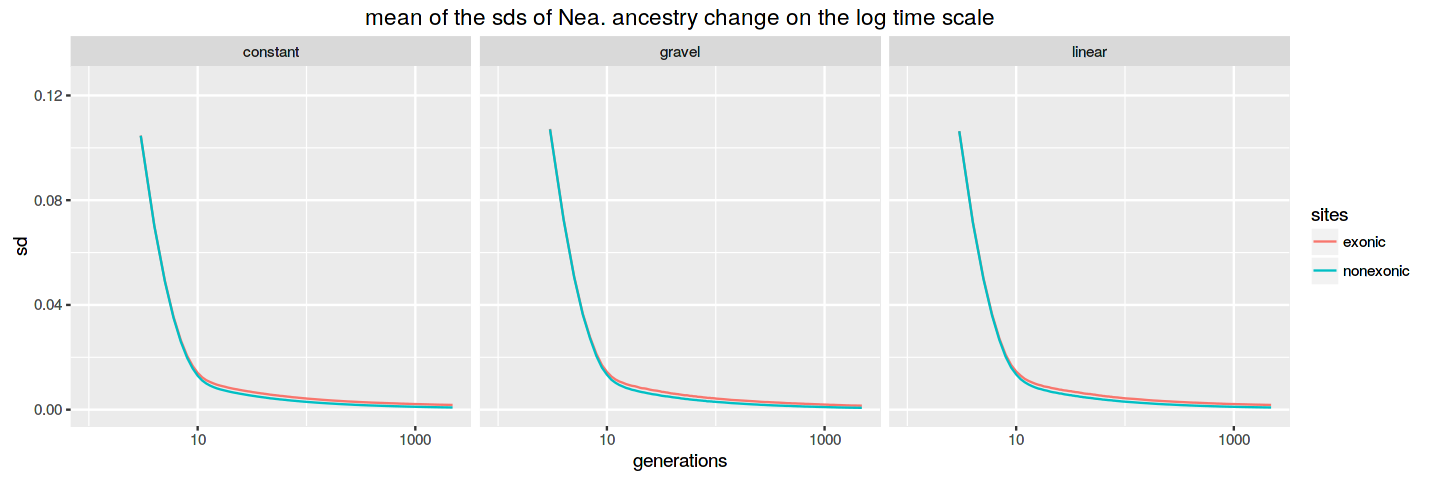

In [9]:
plot_statistic(trajectories, "sd")
plot_statistic(trajectories, "sd", log_scale=TRUE)

### Nea. trajectories on neutral exonic/non-exonic sites for each individual replicate

The slope doesn't seem to be different between different demographic models. Therefore, selection efficacy is not particularly different under different $N_e$ of the population that received gene flow from Neanderthals.

What changes is the variance in the final level of Nea. ancestry in the population. This is highest under the Gravel model, which is not surprising, because this model predicts a _very_ long period of a _very_ narrow bottleneck (i.e. high drift for > 20 thousand years).

The variance between different replicates is caused by drift very early after the admixture pulse (recombination early after admixture has a higher chance of removing larger blocks of Nea. ancestry).

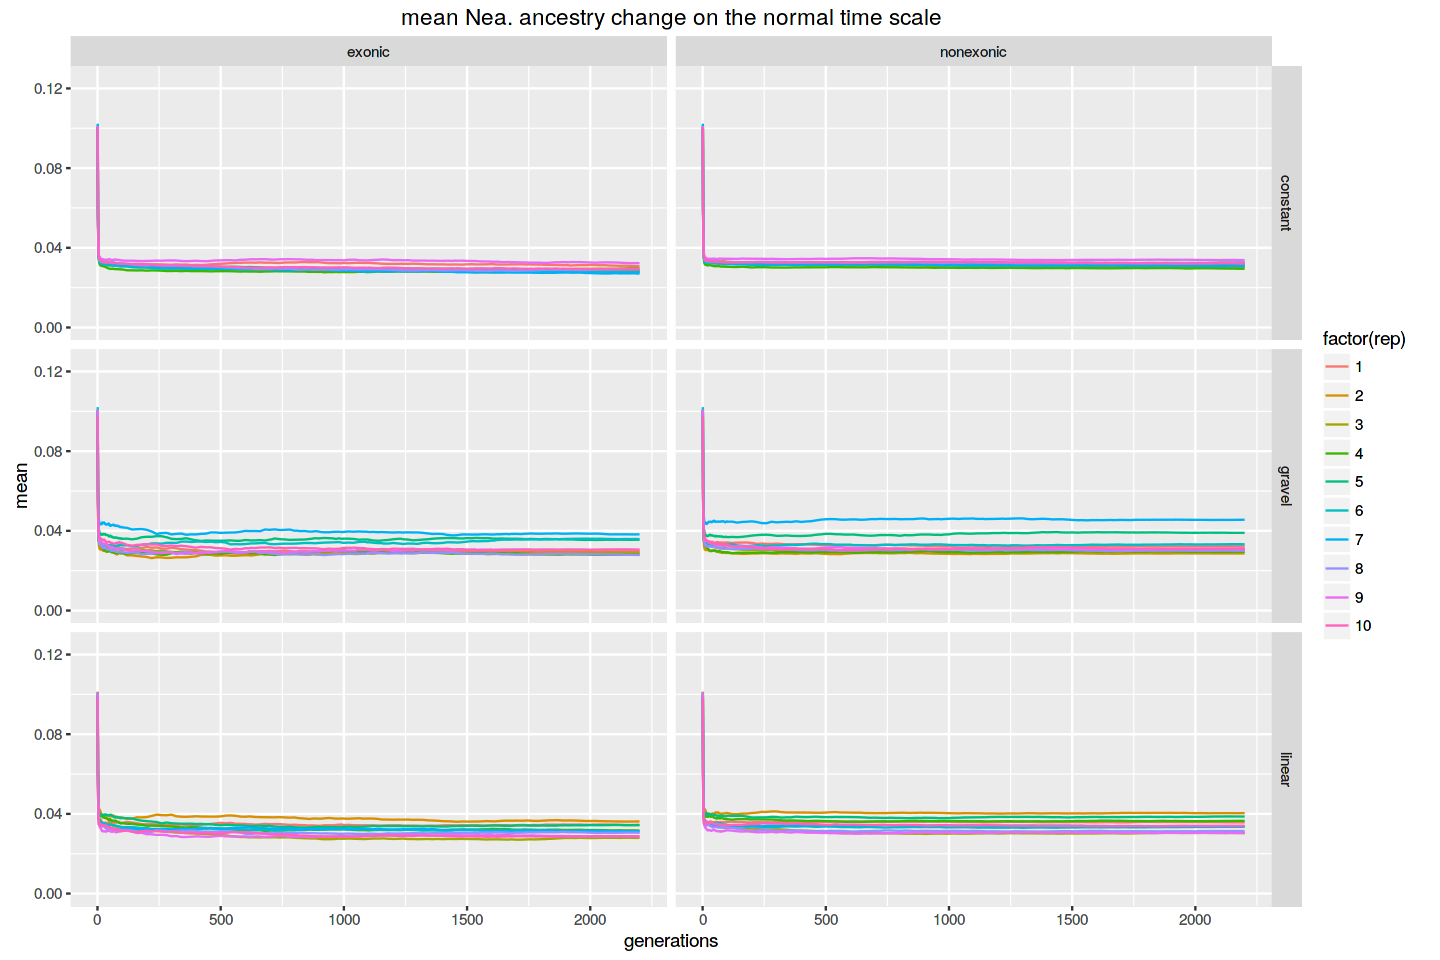

In [10]:
plot_replicates(trajectories, "mean")

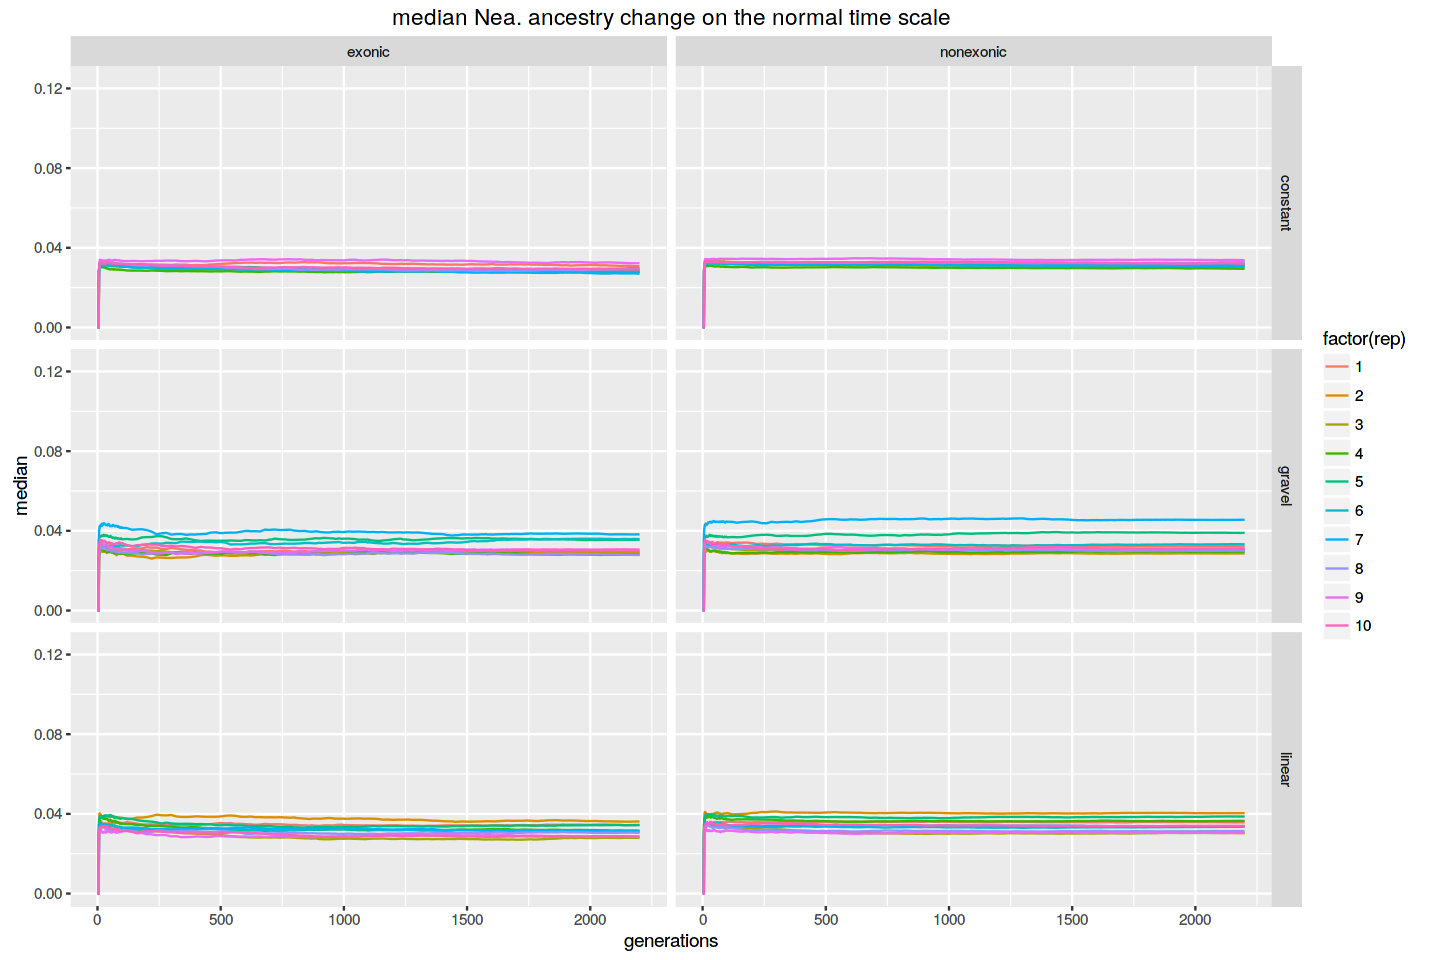

In [11]:
plot_replicates(trajectories, "median")

Warning message:
“Removed 20 rows containing missing values (geom_path).”

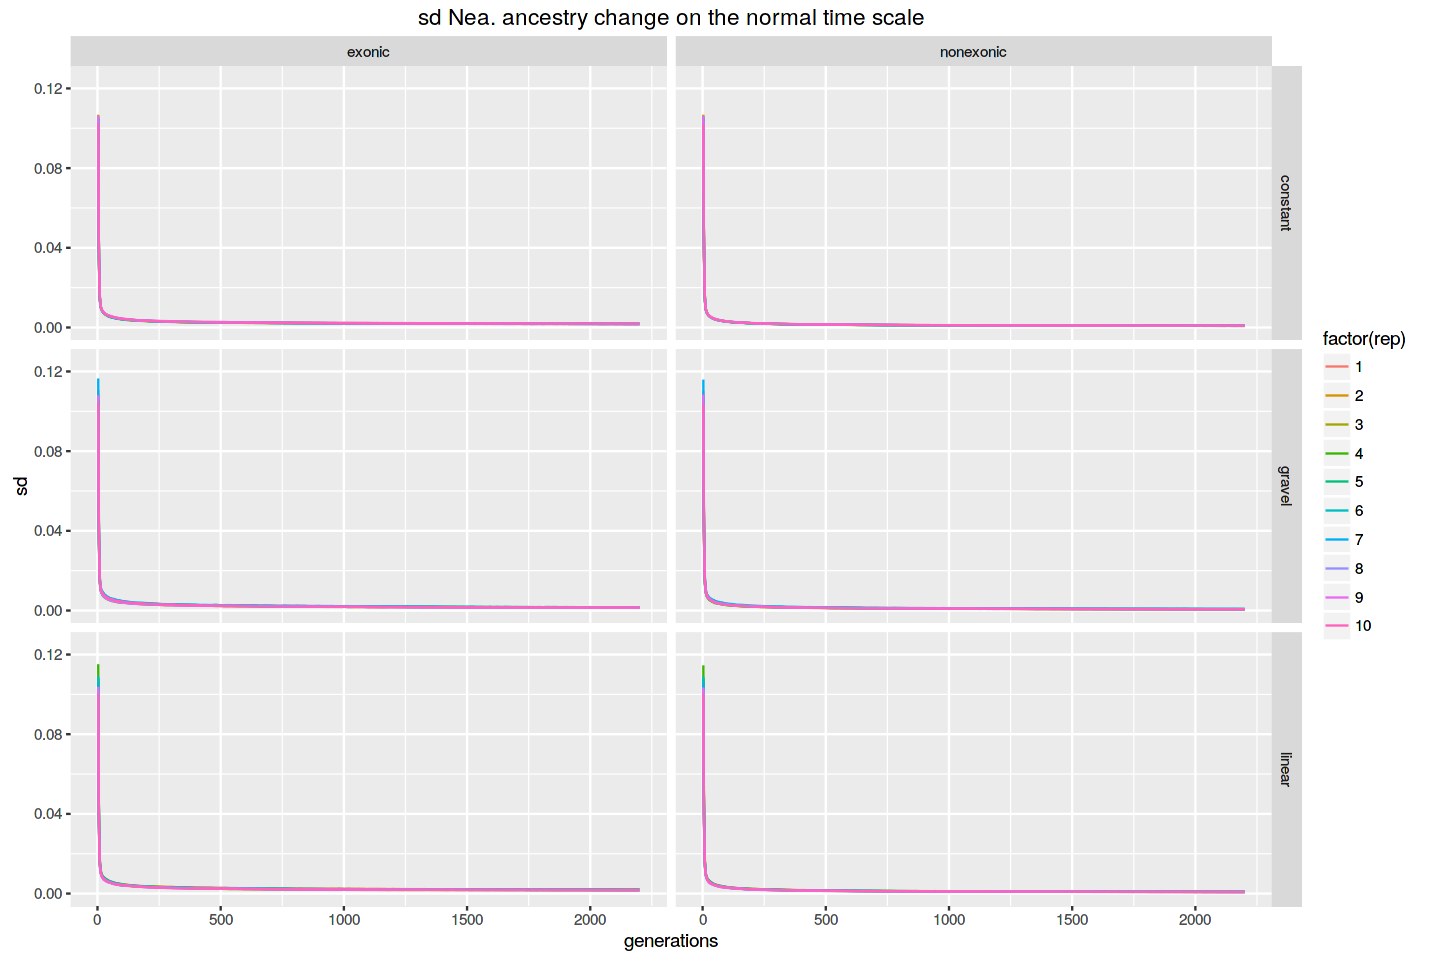

In [12]:
plot_replicates(trajectories, "sd")

In [9]:
load_trajectories

function(sim_dir, scenario, h, init_nea, sites_subset) {
    if (!sites_subset %in% c("exonic", "nonexonic"))
        stop("Illegal subset of sites specified (must be \"exonic\" or \"nonexonic\").")

    # compose the pattern describing all input tables
    pattern <- paste0(scenario,
                      "__h_", h,
                      "__init_nea_", init_nea,
                      "__rep_.*",
                      "__", sites_subset, "_sites.txt")

    # get paths of all input tables
    files <- list.files(sim_dir, pattern, full.names=TRUE)

    # load each table individually
    tables <- lapply(seq_along(files),
           function(i) {
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=i,
                              model=scenario,
                              sites=sites_subset)
           })

    # merge all dataframes into one and return the result
    do.call(rbind, tables)
}

In [8]:
files <- list.files("../simulations/dilution/", "shortterm_dilution_.*__exonic.*", full.names = TRUE)
shortterm <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "short-term dilution", sites="exonic")
    }) %>% bind_rows()

files <- list.files("../simulations/dilution/", "longterm_dilution_.*__exonic.*", full.names = TRUE)
longterm <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "long-term dilution", sites="exonic")
    }) %>% bind_rows()

files <- list.files("../simulations/dilution/", "control.*__exonic.*", full.names = TRUE)
control <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "control", sites="exonic")
    }) %>% bind_rows()

In [9]:
do.call(rbind, list(shortterm, longterm, control)) -> x

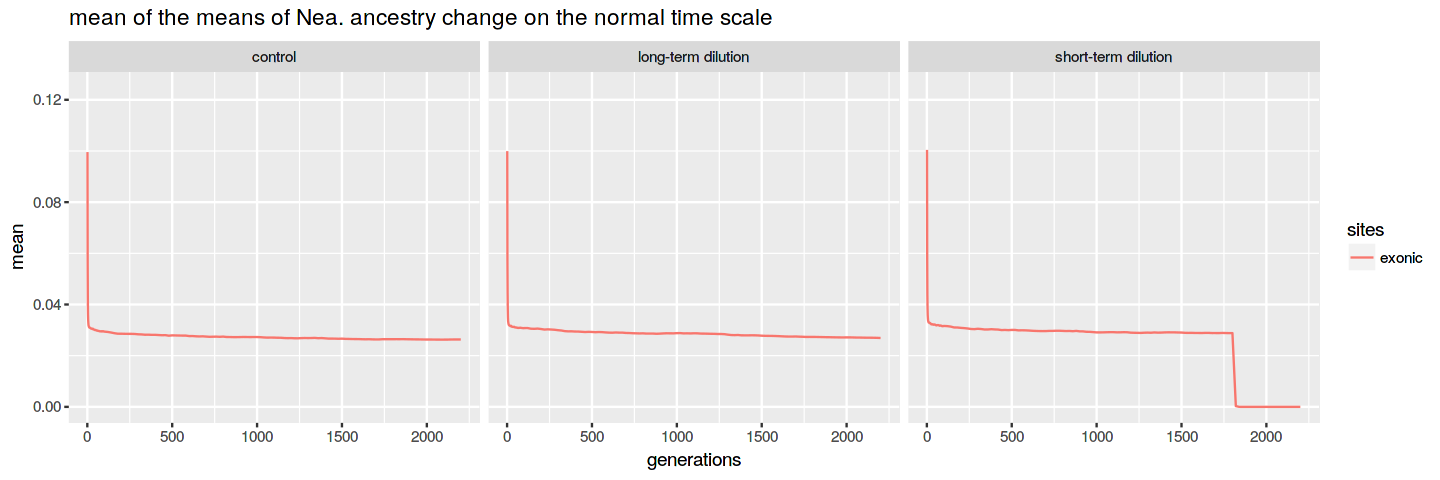

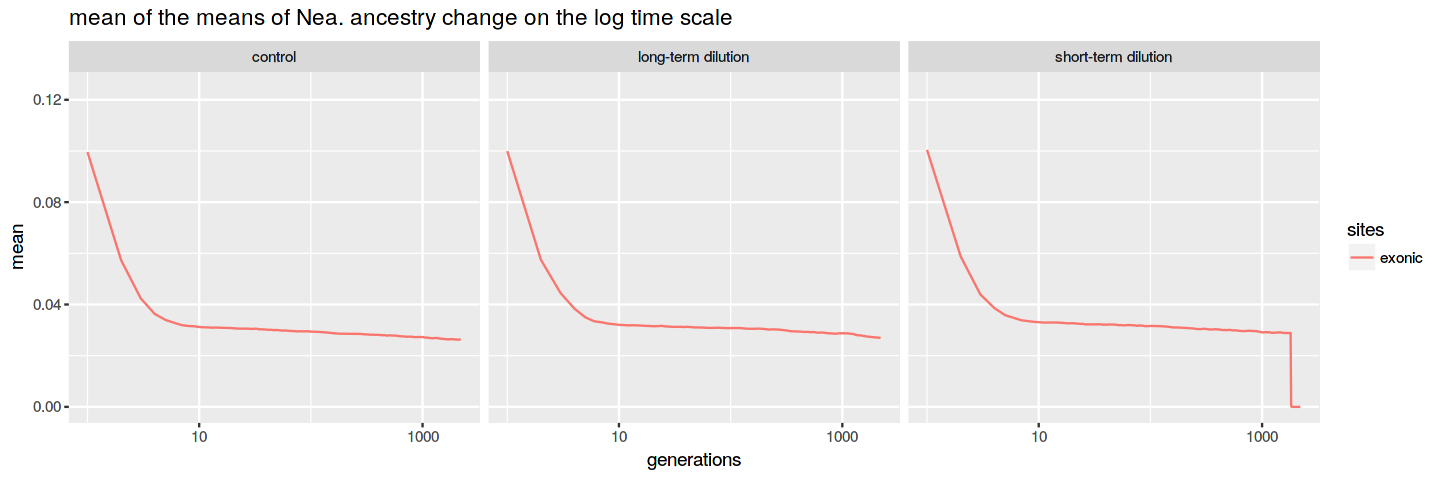

In [11]:
plot_statistic(x, "mean")
plot_statistic(x, "mean", log_scale=TRUE)

<br><br><br><br><br><br><br><br><br><br><br>
Old stuff, feel free to ignore this...
<br>
# Archive of old simulations of regularly spaced neutral markers in exons

The plots above show results of simulations of neutral markers within exons and outside exons, subsampled from the coordinates of the real admixture array. In the simulations bellow, Neanderthal ancestry was calculated only using the regulardly spaced (every $10^4$ bp) markers within exonic regions.

In [14]:
suppressPackageStartupMessages(source("../R/process_trajectories.R"))

### Plots of averages of summary statistics for different values of $h$

In [15]:
options(repr.plot.width=10, repr.plot.height=5)

In [16]:
plot_all_h <- function(init_nea, func, ...) {
    for (h in c("0.5", "0.1", "0.0")) {
        load_trajectories(sim_dir="../simulations/exonic_only/", scenario="exome_only", h, init_nea, "exonic") %>%
            func(title=paste("h =", h, ", init_nea =", init_nea), ...) %>%
            print
    }
}

Warning message:
“Removed 10 rows containing missing values (geom_path).”Warning message:
“Removed 11 rows containing missing values (geom_path).”

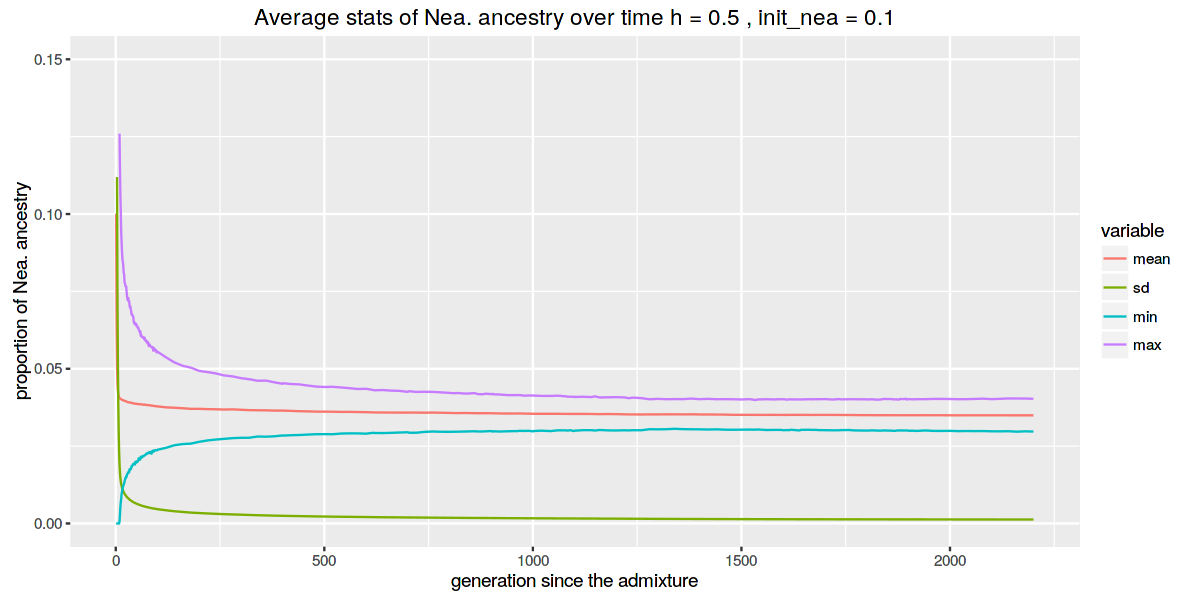

Warning message:
“Removed 14 rows containing missing values (geom_path).”

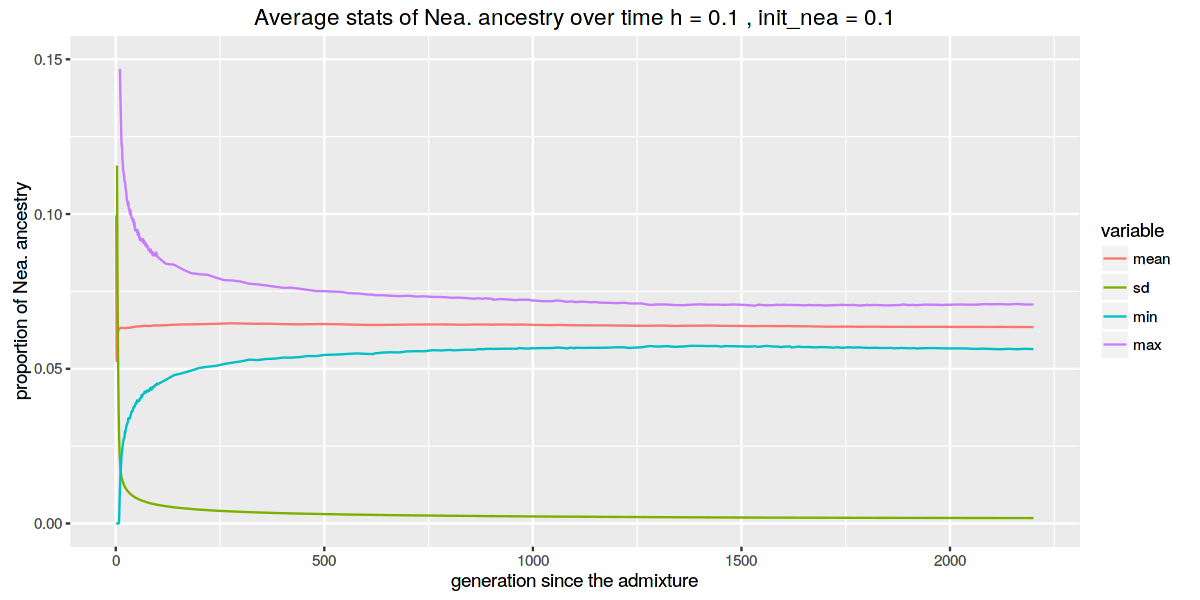

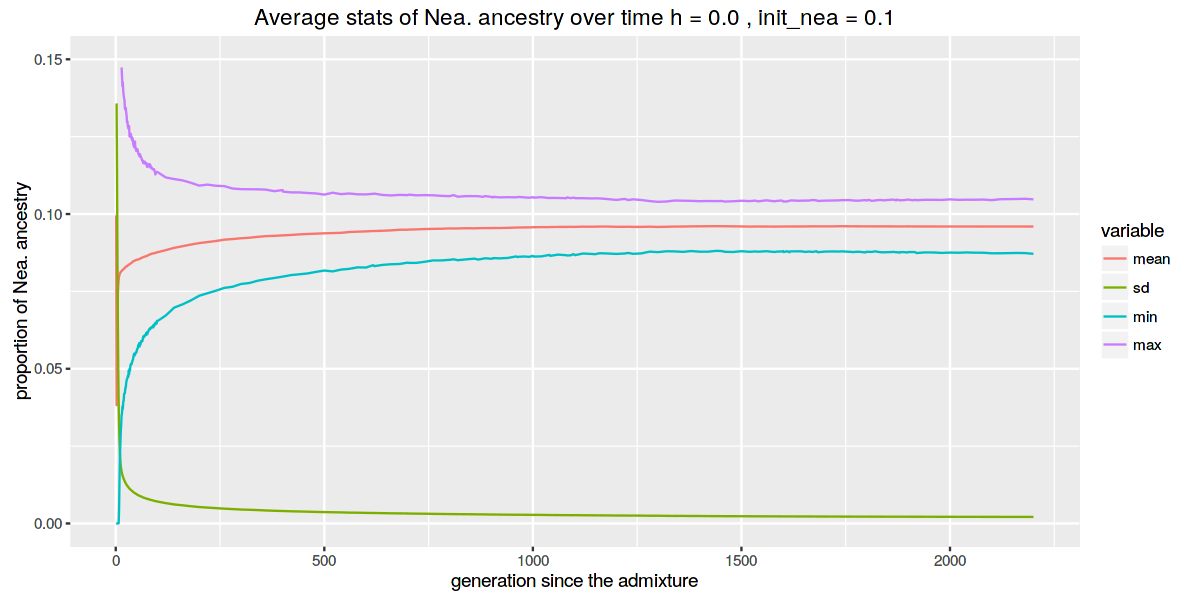

In [17]:
plot_all_h(init_nea=0.1, plot_all_stats)

# Plots of averages of summary statistics for different values of $h$ (log scale)

Warning message:
“Removed 10 rows containing missing values (geom_path).”Warning message:
“Removed 11 rows containing missing values (geom_path).”

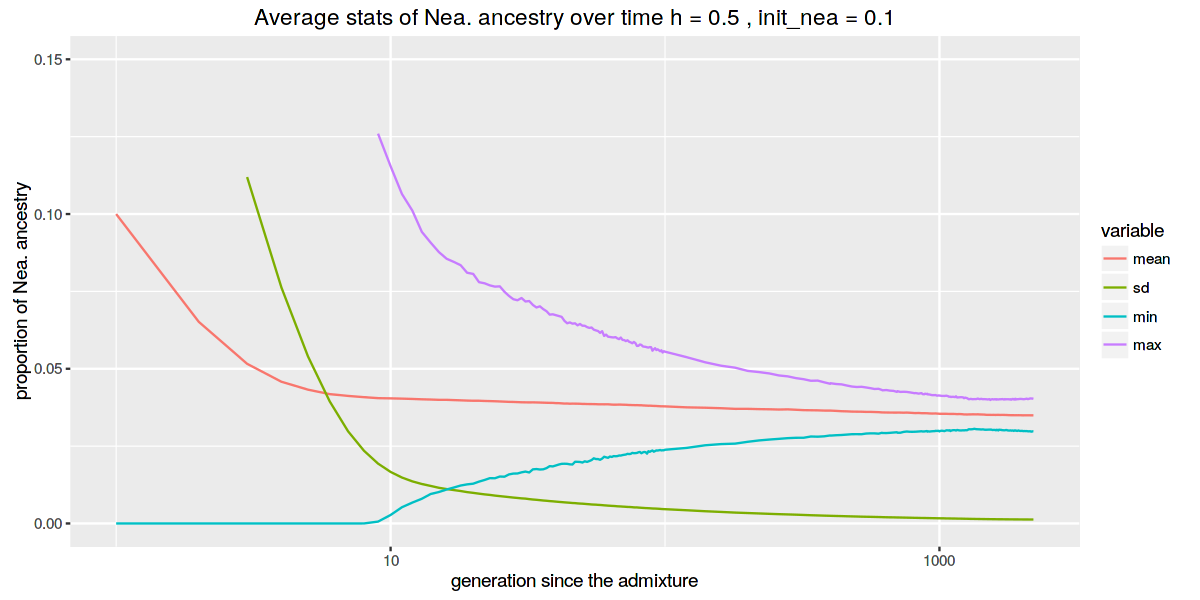

Warning message:
“Removed 14 rows containing missing values (geom_path).”

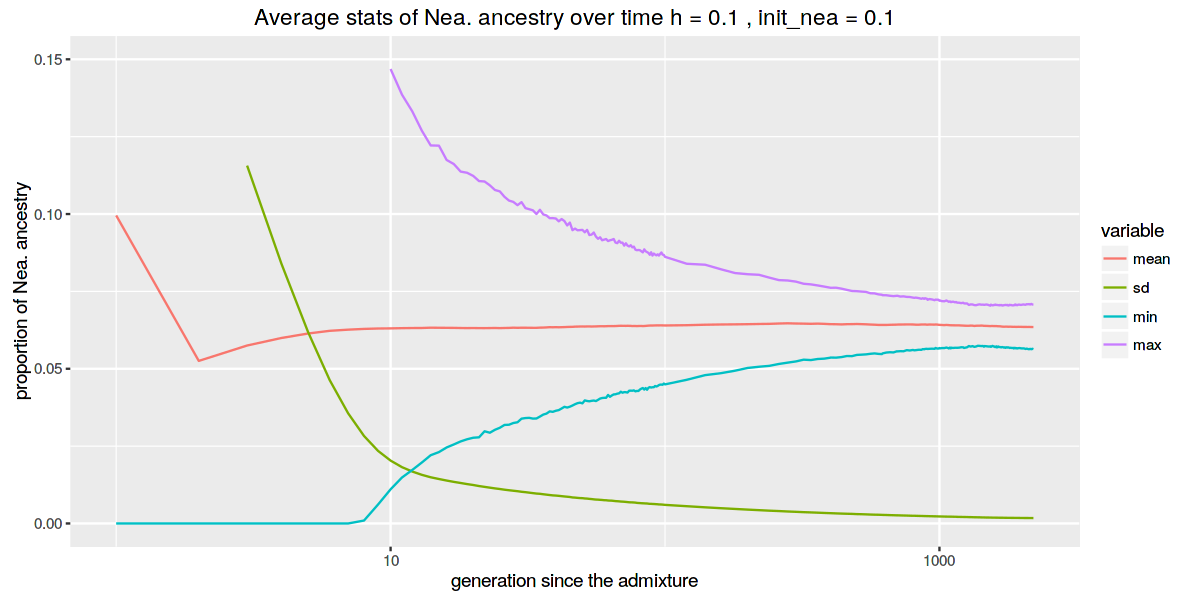

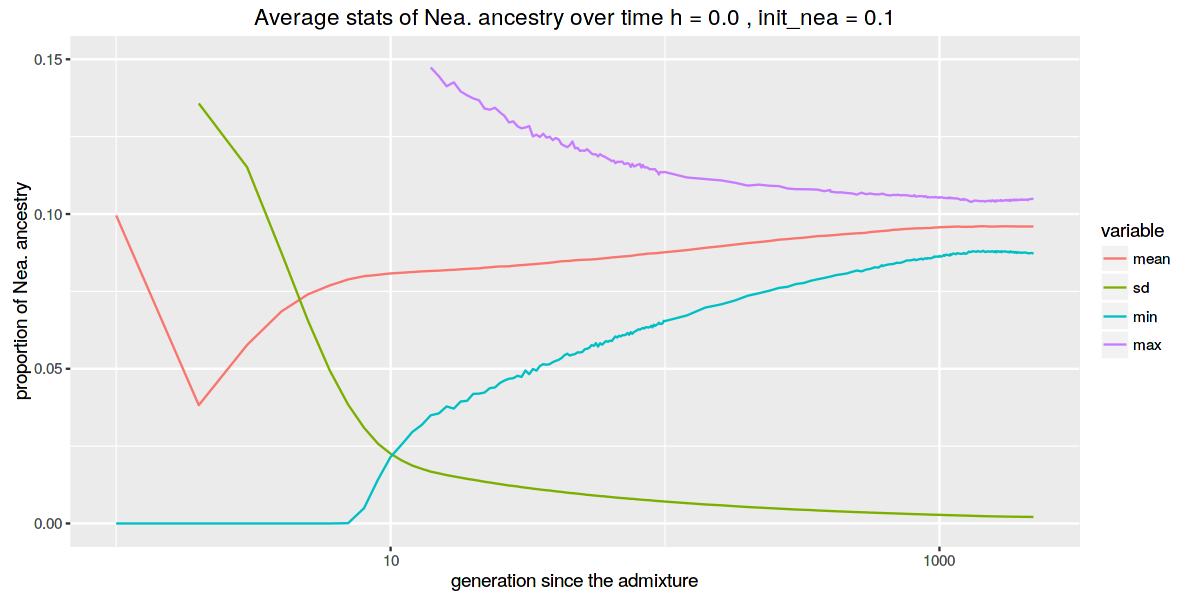

In [18]:
plot_all_h(init_nea=0.1, plot_all_stats, log_scale=TRUE)

# Mean Nea. ancestry over time in individual replicates

In [19]:
options(repr.plot.width=10, repr.plot.height=4)

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


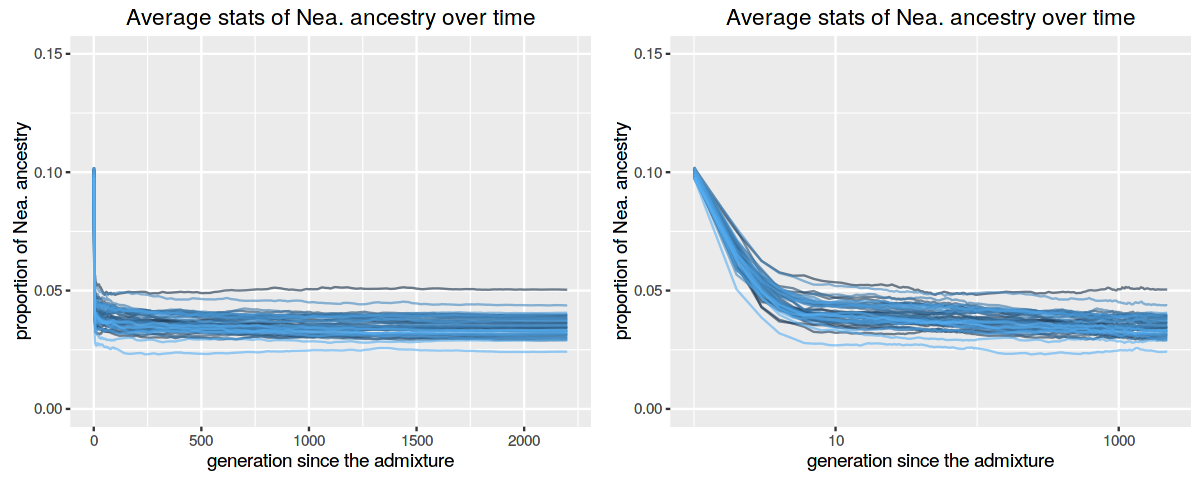

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


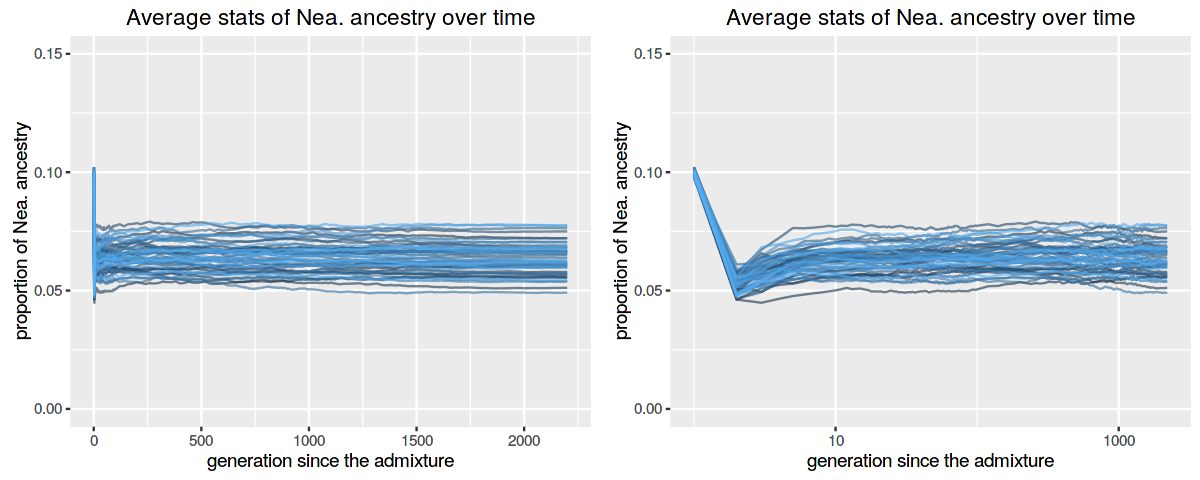

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


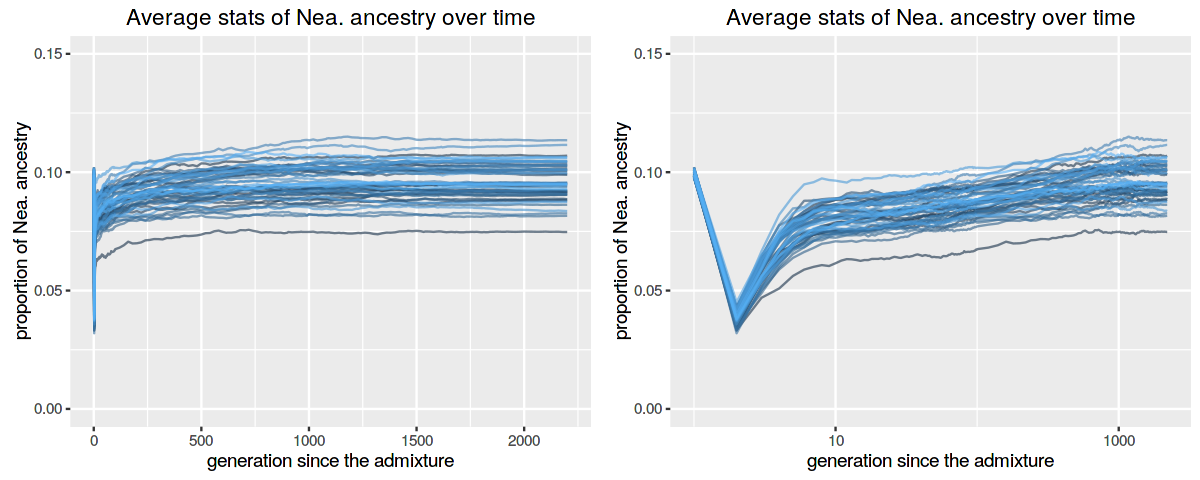

In [20]:
plot_all_h(init_nea=0.1, plot_one_stat, stat="mean")

# Median Nea. ancestry over time in individual replicates

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


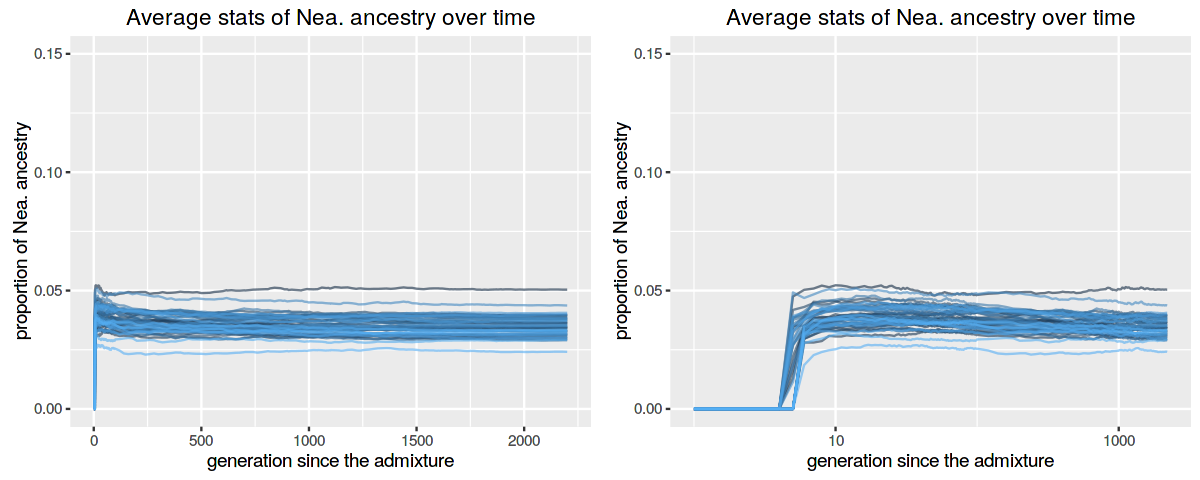

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


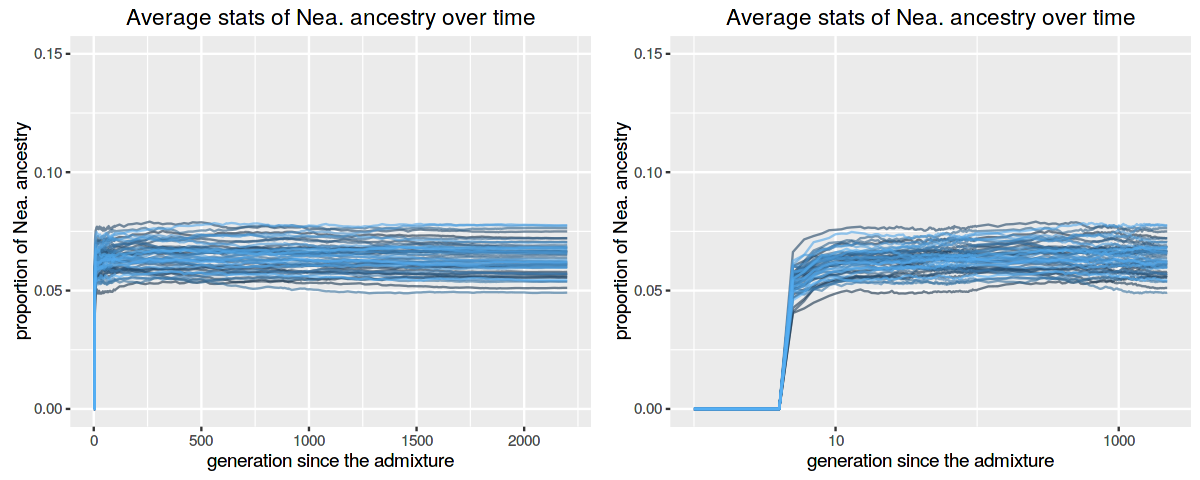

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


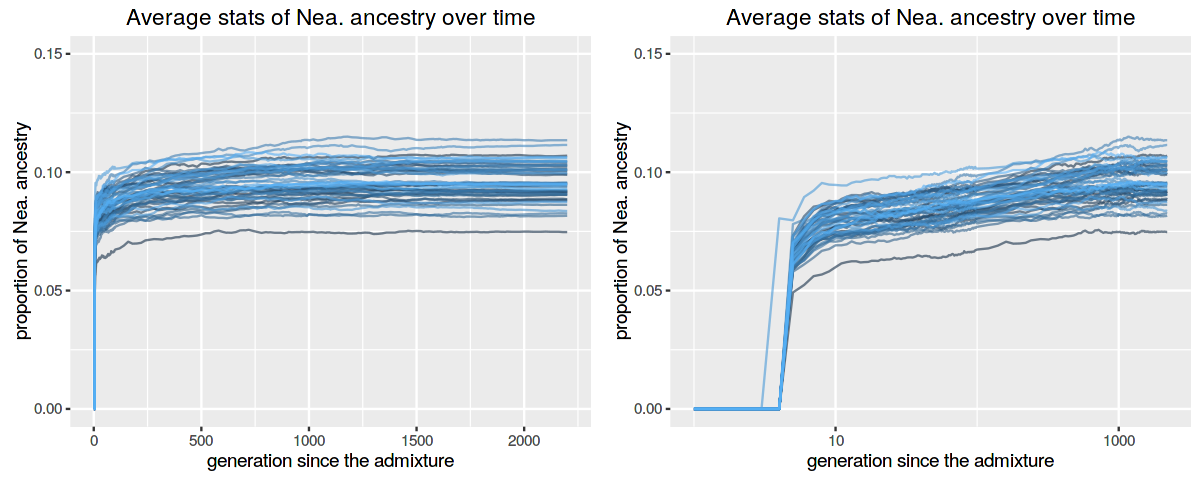

In [21]:
plot_all_h(init_nea=0.1, plot_one_stat, stat="median")

# Standard deviation of Nea. ancestry over time in individual replicates

Warning message:
“Removed 100 rows containing missing values (geom_path).”Warning message:
“Removed 100 rows containing missing values (geom_path).”

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


Warning message:
“Removed 95 rows containing missing values (geom_path).”Warning message:
“Removed 95 rows containing missing values (geom_path).”

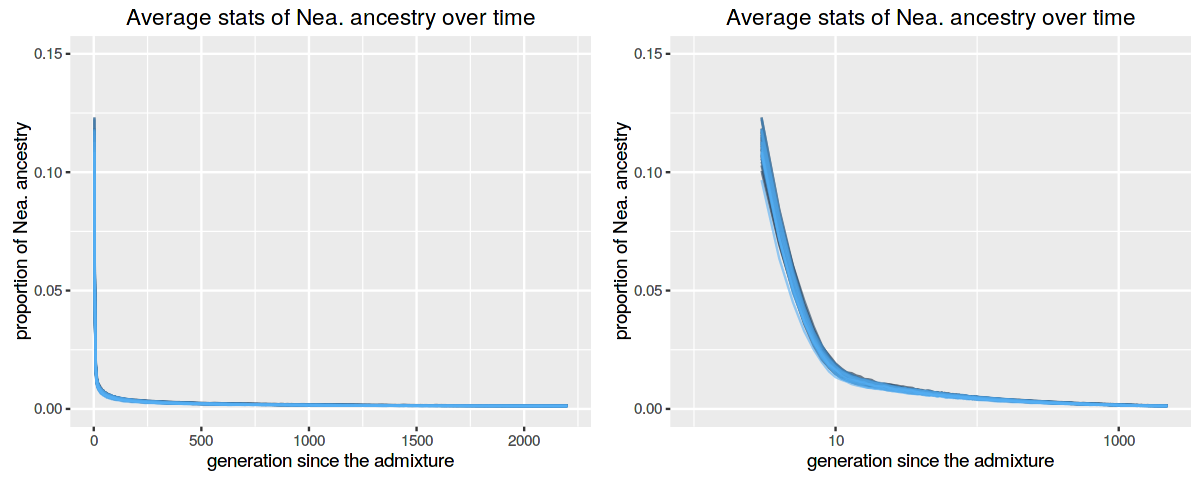

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


Warning message:
“Removed 50 rows containing missing values (geom_path).”Warning message:
“Removed 50 rows containing missing values (geom_path).”

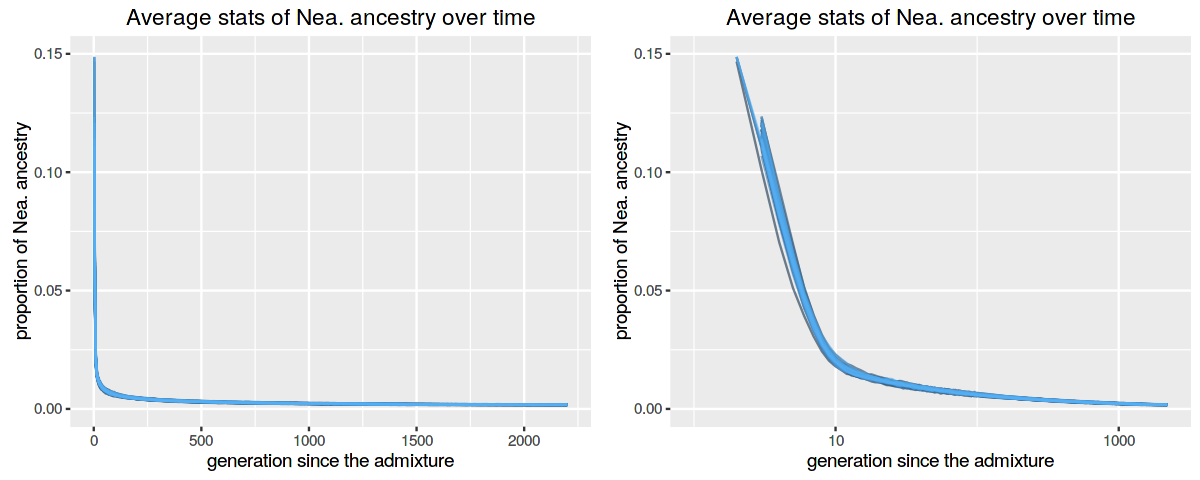

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


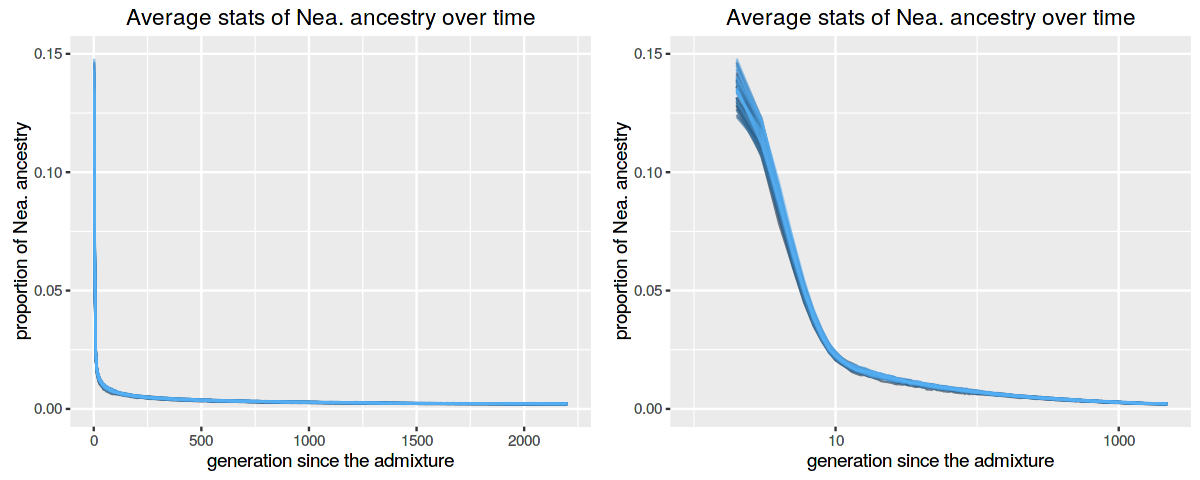

In [22]:
plot_all_h(init_nea=0.1, plot_one_stat, stat="sd")